In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.09
delta_lp = None
delta_sc = None
delta_lc = 0.03

same_day = True
purchase_time = '09:45:00'

max_loss = 2.0

commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

initial_portfolio_value = 10000
    
is_spread = False
if (delta_sp is not None and delta_lp is None) or (delta_sp is not None and delta_lp is None):
    is_spread = True


In [2]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if strike_sc is not None:   
        if underlying > strike_sc:
            total_lost = total_lost + (underlying - strike_sc)*100
    if strike_lc is not None:
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if strike_sp is not None:
        if underlying < strike_sp:
            total_lost = total_lost + (strike_sp - underlying)*100
    if strike_lp is not None:
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    # TODO : change this line so quote date and expiration date can be different
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    if strike_sp is None:
        bb_cost_sp = 0.0
    else:
        df_sp = df1[df1['strike']==strike_sp].min()
        bb_cost_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    if strike_lp is None:
        bb_cost_lp = 0.0
    else:
        df_lp = df1[df1['strike']==strike_lp].min()
        bb_cost_lp = -1*(df_lp['ask']+df_lp['bid'])/0.02
    
    if strike_sc is None:
        bb_cost_sc = 0.0
    else:
        df_sc = df1[df1['strike']==strike_sc].min()
        bb_cost_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    if strike_lc is None:
        bb_cost_lc = 0.0
    else:
        df_lc = df1[df1['strike']==strike_lc].min()
        bb_cost_lc = -1*(df_lc['ask']+df_lc['bid'])/0.02
        
    curr_cost_to_buy_back = bb_cost_sp + bb_cost_lp + bb_cost_sc + bb_cost_lc
    # return curr_value
    if curr_cost_to_buy_back >= max_loss*curr_collected:
        return pd.Series([curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([0.0, curr_comm])

In [3]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = None
df_trades['strike_lp'] = None
df_trades['strike_sc'] = None
df_trades['strike_lc'] = None
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0

In [4]:
trade_count = 0

# Create new filtered dataframe with only calls above target delta
if delta_sc is not None and delta_sc > 0.0:
    df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    #apply dataframe to get strikes and collect premium
    df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
    trade_count = trade_count + 1

if delta_lc is not None and delta_lc > 0.0:
    df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
    df_trades['collected_lc'] = df_trades['collected_lc']*-1
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_sp is not None and delta_sp > 0.0:
    df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_lp is not None and delta_lp > 0.0:
    df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
    df_trades['collected_lp']=df_trades['collected_lp']*-1
    trade_count = trade_count + 1

df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_lc'] + df_trades['collected_sp'] + df_trades['collected_lp']
df_trades['commission'] = trade_count * commission

In [5]:
df_trades.head()

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,strike_lc,delta_sp,delta_lp,delta_sc,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization
0,2022-01-03,2022-01-03,0.0,-25.0,127.5,0.0,102.5,0.0,4755.0,None,...,4830.0,0.0986,0.0,0.0,0.0304,0.0,3.0,0.0,0.0,0.0
1,2022-01-05,2022-01-05,0.0,-27.5,152.5,0.0,125.0,0.0,4750.0,None,...,4830.0,0.1073,0.0,0.0,0.0306,0.0,3.0,0.0,0.0,0.0
2,2022-01-07,2022-01-07,0.0,-45.0,170.0,0.0,125.0,0.0,4655.0,None,...,4760.0,0.0979,0.0,0.0,0.0357,0.0,3.0,0.0,0.0,0.0
3,2022-01-10,2022-01-10,0.0,-45.0,222.5,0.0,177.5,0.0,4570.0,None,...,4695.0,0.1046,0.0,0.0,0.0312,0.0,3.0,0.0,0.0,0.0
4,2022-01-12,2022-01-12,0.0,-45.0,210.0,0.0,165.0,0.0,4675.0,None,...,4790.0,0.1006,0.0,0.0,0.0350,0.0,3.0,0.0,0.0,0.0


In [6]:
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), filtered_df), axis=1).T.values
    
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"Processed {curr_time}")

Processed 10:00:00
Processed 10:30:00
Processed 11:00:00
Processed 11:30:00
Processed 12:00:00
Processed 12:30:00
Processed 13:00:00
Processed 13:30:00
Processed 14:00:00
Processed 14:30:00
Processed 15:00:00
Processed 15:30:00
Processed 16:00:00


In [7]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']

In [8]:
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0
initial_portfolio_value = 10000
df_trades['net_cumsum']=df_trades['net'].cumsum()

df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
df_trades['transaction_return'].iloc[0] = df_trades['net'].iloc[0] / initial_portfolio_value

df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

df_trades.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,delta_sc,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization,net_cumsum,transaction_return,cum_return
0,2022-01-03,2022-01-03,0.0,-25.0,127.5,0.0,102.5,375.0,4755.0,None,...,0.0,0.0304,-278.5,6.0,9721.5,0.0,0.0,-278.5,-0.027850,-0.02785
1,2022-01-05,2022-01-05,0.0,-27.5,152.5,0.0,125.0,257.5,4750.0,None,...,0.0,0.0306,-138.5,6.0,9583.0,0.0,0.0,-417.0,-0.014247,-0.04170
2,2022-01-07,2022-01-07,0.0,-45.0,170.0,0.0,125.0,267.5,4655.0,None,...,0.0,0.0357,-148.5,6.0,9434.5,0.0,0.0,-565.5,-0.015496,-0.05655
3,2022-01-10,2022-01-10,0.0,-45.0,222.5,0.0,177.5,375.0,4570.0,None,...,0.0,0.0312,-203.5,6.0,9231.0,0.0,0.0,-769.0,-0.021570,-0.07690
4,2022-01-12,2022-01-12,0.0,-45.0,210.0,0.0,165.0,382.5,4675.0,None,...,0.0,0.0350,-223.5,6.0,9007.5,0.0,0.0,-992.5,-0.024212,-0.09925


In [9]:

                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [10]:
df_trades.tail(30)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,delta_sc,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization,net_cumsum,transaction_return,cum_return
79,2022-06-10,2022-06-10,0.0,-75.0,272.5,0.0,197.5,430.00,3865.0,None,...,0.0,0.0308,-238.50,6.0,6670.50,0.0,0.0,-3329.50,-0.034520,-0.332950
80,2022-06-13,2022-06-13,0.0,-90.0,335.0,0.0,245.0,490.00,3710.0,None,...,0.0,0.0340,-251.00,6.0,6419.50,0.0,0.0,-3580.50,-0.037628,-0.358050
81,2022-06-14,2022-06-14,0.0,-80.0,257.5,0.0,177.5,0.00,3665.0,None,...,0.0,0.0343,174.50,3.0,6594.00,0.0,0.0,-3406.00,0.027183,-0.340600
82,2022-06-15,2022-06-15,0.0,-105.0,420.0,0.0,315.0,0.00,3660.0,None,...,0.0,0.0327,312.00,3.0,6906.00,0.0,0.0,-3094.00,0.047316,-0.309400
83,2022-06-16,2022-06-16,0.0,-75.0,252.5,0.0,177.5,0.00,3605.0,None,...,0.0,0.0304,174.50,3.0,7080.50,0.0,0.0,-2919.50,0.025268,-0.291950
84,2022-06-17,2022-06-17,0.0,-75.0,305.0,0.0,230.0,595.00,3620.0,None,...,0.0,0.0325,-371.00,6.0,6709.50,0.0,0.0,-3290.50,-0.052397,-0.329050
85,2022-06-21,2022-06-21,0.0,-57.5,257.5,0.0,200.0,0.00,3690.0,None,...,0.0,0.0349,197.00,3.0,6906.50,0.0,0.0,-3093.50,0.029361,-0.309350
86,2022-06-22,2022-06-22,0.0,-65.0,212.5,0.0,147.5,0.00,3670.0,None,...,0.0,0.0377,144.50,3.0,7051.00,0.0,0.0,-2949.00,0.020922,-0.294900
87,2022-06-23,2022-06-23,0.0,-50.0,245.0,0.0,195.0,0.00,3720.0,None,...,0.0,0.0317,192.00,3.0,7243.00,0.0,0.0,-2757.00,0.027230,-0.275700
88,2022-06-24,2022-06-24,0.0,-52.5,240.0,0.0,187.5,0.00,3785.0,None,...,0.0,0.0344,184.50,3.0,7427.50,0.0,0.0,-2572.50,0.025473,-0.257250


In [11]:
def net2pct(x):
    return (x / initial_portfolio_value)*100


def pct2net(x):
    return initial_portfolio_value * x/100



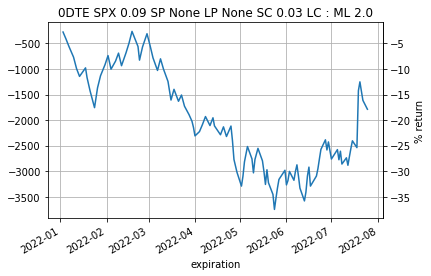

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
secax = ax.secondary_yaxis('right', functions=(net2pct, pct2net))
secax.set_ylabel('% return')
df_trade_plot.plot(ax=ax)
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")